# Simple shear test of Lubby2 Model

In [12]:
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 22})

In [13]:
GM0  = 9.54e3
KM0  = 2.78e4
GK0  = 6.27e4
mK   = -0.254
mvK  = -0.327
mvM  = -0.267
etaK0= 1.66e5
etaM0= 4.03e7
tmax = 15.

shear_stress = 5.

In [14]:
build_release = 'mfront --obuild --interface=generic Lubby2mod.mfront'
build_debug = 'mfront --obuild --interface=generic --debug Lubby2mod.mfront'
os.system(build_release)

0

In [15]:
m    = mtest.MTest()
m.setMaximumNumberOfSubSteps(1)
m.setBehaviour('generic', './src/libBehaviour.so', 'Lubby2mod')

In [16]:
m.setExternalStateVariable("Temperature", 293.15)
m.setImposedStress('SXX', 0.0)
m.setImposedStress('SYY', 0.0)
m.setImposedStress('SZZ', 0.0)
m.setImposedStress('SXZ', 0.0)
m.setImposedStress('SYZ', 0.0)
m.setImposedStress('SXY', {0: 0, 1.e-5 : shear_stress * np.sqrt(2.), tmax : shear_stress * np.sqrt(2.)}) #Kelvin Mapping of shear components!!

In [17]:
m.setMaterialProperty('YoungModulus', (9 * GM0 * KM0) / (3 * KM0 + GM0))
m.setMaterialProperty('PoissonRatio', (3 * KM0 - 2 * GM0) / (2 * GM0 + 6 * KM0))
m.setMaterialProperty('KelvinShearModulus', GK0)
m.setMaterialProperty('KelvinViscosity', etaK0)
m.setMaterialProperty('MaxwellViscosity', etaM0)
m.setMaterialProperty('KelvinElasticParameter', mK)
m.setMaterialProperty('MaxwellViscoParameter', mvM)
m.setMaterialProperty('KelvinViscoParameter', mvK)

In [18]:
def analytical_solution(t):
    sig_eff = np.sqrt(3.)*shear_stress
    
    shear_softening = lambda P0, m, seff: P0 * np.exp(m*seff)

    GK=shear_softening(GK0,mK,sig_eff)
    etaK=shear_softening(etaK0,mvK,sig_eff)
    etaM=shear_softening(etaM0,mvM,sig_eff)

    return ((1./GM0 + t/etaM)*shear_stress + 1./GK*(1.-np.exp(-GK/etaK*t))*shear_stress)/2.

In [19]:
s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

In [20]:
def run_sim(t_discrete):
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[3]/np.sqrt(2.)) #Kelvin mapping backwards!
    return numerical

In [21]:
times = np.append(np.linspace(0,1e-5,10),np.linspace(2.e-5,tmax,20))
numerical = run_sim(times)

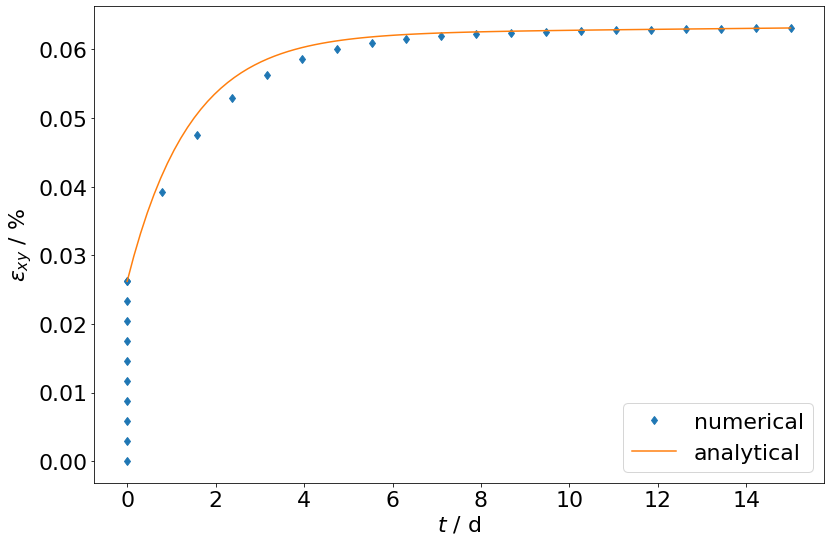

In [23]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,numerical*100.,label='numerical',ls='',marker='d')
ax.plot(np.linspace(0,tmax,100),analytical_solution(np.linspace(0,tmax,100))*100.,label='analytical')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{xy}$ / %')
fig.tight_layout();
ax.legend();